## Importing all the Required libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from darts import TimeSeries
import pandas as pd
import nltk
import numpy as np
import spacy
from spacy import displacy
from spacy import tokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import huggingface_hub
import matplotlib.pyplot as plt
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.statistics import plot_acf, check_seasonality
from darts.dataprocessing.transformers import MissingValuesFiller
# for reproducibility
torch.manual_seed(1)
np.random.seed(1)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings("ignore")

/Users/rajenderkapur/miniconda3/envs/stockprice/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


## Table of Contents
### Time Series Analysis
1) Analysis with the use of just Macro Economic Data
2) Include the sentiment analysis data 
    2.1 Investigate forecasting with all the sentiment analysis techniques
    2.2 Conclude the best sentiment analysis technique
3) In Sentiment Analysis also include financial documents and perform finbert on it too

### Reading the Macro-data and Sentiment Data for Reliance

In [3]:
# This is the excel file to read the macro data
Macrodf = pd.read_excel('Stock-data.xlsx')

# Removing the first unamed column 
Macrodf = Macrodf.drop(columns=['Unnamed: 0'])

# Sentiment Data 
sentiments = pd.read_excel('allarticles.xlsx')
sentiments = sentiments.drop(columns='Unnamed: 0')

#Changing the dtype of the date column to get into correct date-time format
Macrodf.Date = pd.to_datetime(Macrodf.Date)

# Renaming the last two columns to the right name 
#! Put this in the data collection code
renamingcols = {'INR_x':'Gold_Price','INR_y':'USD_Exchange_Rate','INR':'Brent_Oil'}
Macrodf = Macrodf.rename(columns=renamingcols)


In [49]:
sentiments[['Date.3','Tweets']]['Date.3'].max()

Timestamp('2022-09-14 00:00:00')

## PreProcessing the Text Data and removing outliers from the macroeconomic data

In [24]:
def todatetime(dataframe,datecols=['Date','Date.1','Date.2','Date.3']):
    '''
    Function to convert all the different date columns columns into pandas datetime format
    '''
    for col in datecols:
        dataframe[col] = pd.to_datetime(pd.to_datetime(dataframe[col]).dt.date)
    return dataframe


def cleaning(dataframe,opinioncols=['Politics','Headlines','News_titles','Tweets']):
    '''
    Cleaning function including processing and stopwords removal as well
    '''
    # First just keeping words and removing special characters in this case
    dataframe[opinioncols] = dataframe[opinioncols].replace('[^a-zA-Z]'," ",regex = True)
    # Getting all the stopwords
    all_stopwords = stopwords.words('english')
    # Removing some stopwords which may be important
    all_stopwords.remove('not')
    all_stopwords.remove("wasn't")
    # Lemmatizing the words
    wnl = WordNetLemmatizer()
    # Then removing all the stopwords
    for col in opinioncols:
        processed = []
        for i in range(len(dataframe[col])):
            # Lowering all the sentences before stemming and lemmatosation
            processing = str(dataframe[col][i]).lower()
            processing = nltk.word_tokenize(processing)
            processing = [wnl.lemmatize(word) for word in processing if word not in all_stopwords]
            final = ' '.join(processing)
            processed.append(final)
        # This is to get the right values in the column
        dataframe[col] = processed
    return dataframe


def slicingdf(dataframe):
    '''
    This is the slicing function to split dataframe into differnt dataframes from 4 different sources the number of sources can be toggled
    from the function argument
    '''
    # The US political data sentiments from reddit
    df1 = dataframe.iloc[:,0:2]

    # The Indian Headlines from reddit
    df2 = dataframe.iloc[:,2:4]
    df2.columns = ['Date','Headlines']

    # The Indian News titiles from financial times
    df3 = dataframe.iloc[:,4:6]
    df3.columns = ['Date','News_Titles']

    # The Tweets about reliance from Twitter
    df4 = dataframe.iloc[:,6:8]
    df4.columns = ['Date','Tweets']

    return [df1,df2,df3,df4]


# Combining all the Sentiments from different sources together and making a new dataframe with all sources from the specific date 
def combineSentiments(dataframe):
    '''
    This function is to combine all the dataframes with differnt sources of sentiments together 
    with their dates so you can get combination of all dates together to make sentiment scores on specific dates
    This returns a cleaned dataset with all the sentiments combined on a common date
    df -> df 
    '''
    sentimentlist = []
    list_of_dataframes = slicingdf(dataframe)

    # This groups all sentiments with the right dates and returns list of dataframes with right 
    for dataframe in list_of_dataframes:
        dategrouping = pd.DataFrame(dataframe.groupby(['Date'])[list(dataframe.columns)[1]],columns=[dataframe.columns])
        sentimentlist.append(dategrouping)

    # This here is to combine all the dataframes together as groupby fn causes some inidices problems
    g = []
    for dataframes in sentimentlist:
        dataframes.to_clipboard(index=False)
        dataframes=pd.read_clipboard(sep='\t')
        g.append(dataframes)
        
    
    all = pd.merge(pd.merge(g[0],g[1],how='outer',on='Date'),pd.merge(g[2],g[3],how='outer',on='Date'),how='outer',on='Date')
    all = all.fillna('')
    cols = ['Politics', 'Headlines', 'News_Titles','Tweets']
    all['Combined'] = all[cols].apply(lambda row: '.'.join(row.values.astype(str)), axis=1)
    final = all[['Date','Combined']]
    final = cleaning(final,opinioncols=['Combined'])
    return final


def sentimentAnalysers(dataframe):
    '''
    Different Sentiment Anlysers used 
    1) Vader 
    2) Nltk Sentiment Analyser
    3) Finbert BERT based on bert pre-trained on financial documents used this for analysis --> Same thing as flair
    4) Combination of Twitter BERT pretrained and Financial for News articles 
    Different ones done here to see which one gives the best capture of what is happening with the market
    '''
    dataframe1 = dataframe.copy()
    dataframe2 = dataframe.copy()
    dataframe3 = dataframe.copy()

    # 1) Vader Sentiment Analyser
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    sid_obj = SentimentIntensityAnalyzer()
    '''polarity_scores method of SentimentIntensityAnalyzer object gives a sentiment dictionary,which contains pos, neg, neu,compound scores.'''
    dataframe1['Negative'] = dataframe1.apply(lambda x: sid_obj.polarity_scores(x['Combined'])['neg'],axis=1)
    dataframe1['Positive'] = dataframe1.apply(lambda x: sid_obj.polarity_scores(x['Combined'])['pos'],axis=1)
    dataframe1['Neutral'] = dataframe1.apply(lambda x: sid_obj.polarity_scores(x['Combined'])['neu'],axis=1)
    dataframe1['Max_Sentiment'] = dataframe1[['Negative','Positive','Neutral']].idxmax(axis=1)
    dataframe1 = pd.get_dummies(dataframe1, columns=['Max_Sentiment'])

    # 2) Ntlk Sentiment Analyser
    from nltk.sentiment import SentimentIntensityAnalyzer
    import operator
    sia = SentimentIntensityAnalyzer()
    dataframe2["sentiment_score"] = dataframe2['Combined'].apply(lambda x: sia.polarity_scores(x)["compound"])
    dataframe2["sentiment"] = np.select([dataframe2["sentiment_score"] < 0, dataframe2["sentiment_score"] == 0, 
                            dataframe2["sentiment_score"] > 0],['neg', 'neu', 'pos'])
    dataframe2 = pd.get_dummies(dataframe2, columns=['sentiment'])
    
    # 3) BERT Based Finbert pretrained model
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    from transformers import BertTokenizer,BertForSequenceClassification
    from transformers import pipeline

    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",num_labels=3)
    nlp = pipeline('sentiment-analysis',model =finbert,tokenizer = tokenizer )

    dataframe3['Label'] = dataframe3.apply(lambda x: nlp(x['Combined'])[0]['label'],axis=1)
    dataframe3['Score'] = dataframe3.apply(lambda x: nlp(x['Combined'])[0]['score'],axis=1)
    dataframe3.Date = pd.to_datetime(dataframe3.Date)
    dataframe3 = pd.get_dummies(dataframe3, columns=['Label'])
    return [dataframe1,dataframe2,dataframe3]


def featureEng(macrodf):
    '''
    Feature Engineering with Macrodataset to create categorical column which says if close price increased or decreased from yesterday
    Hopefully better for the model as a covariate
    '''
    macrodf['Diff'] = macrodf.Close.diff()   
    up_or_down = []
    for i in range(len(macrodf['Diff'])):
        if macrodf['Diff'][i] > 0:
            up_or_down.append('Increase')
        elif macrodf['Diff'][i] < 0:
            up_or_down.append('Decrease')
        else:
            up_or_down.append('Same')
    macrodf['Change'] = up_or_down
    macrodf.Change=macrodf.Change.astype('category').cat.codes
    return macrodf


def removeOutliers(dataframe):
    '''
    In this function we remove outliers, but instead of removing whole rows the outliers are replaced with nan values which are then filled
    This is so that there is min loss of data
    '''
    q_low = dataframe['Gold_Price'].quantile(0.01)
    # q_hi  = dataframe['Gold_Price'].quantile(0.99)
    mask = dataframe['Gold_Price'] < q_low
    dataframe.loc[mask,'Gold_Price'] = np.nan

    q_low1 = dataframe['Brent_Oil'].quantile(0.01)
    mask = dataframe['Brent_Oil'] < q_low1
    dataframe.loc[mask,'Brent_Oil'] = np.nan

    return dataframe

    
def mergingMacroSentiment(macrodf,listsentimentdf):
    '''
    Merging the Macroeconomic and Sentiment dataframe which is done after the outliers are removed from the macroeconomic dataset and
    feature engineering has been performed, so here a list is outputted to get the list of merged dataframes with macro and sentiment df
    with different sentiment analysers
    '''
    macrodf = removeOutliers(macrodf)
    mergedDataframes = []
    for sentimentdf in listsentimentdf:
        macrodf = todatetime(macrodf,datecols=['Date'])
        sentimentdf = todatetime(sentimentdf,datecols=['Date'])
        mergeddf = pd.merge(macrodf,sentimentdf,how='inner',on=['Date'])
        mergeddf = featureEng(mergeddf)
        mergedDataframes.append(mergeddf)
    return mergedDataframes
    
    
def mergingData(tomerge1,tomerge2):
    '''
    This is just a custom funciton which I used to concat two different lists of dataframes the second
    dataframe list is from the fact that it was collected to merge the latest data.
    '''
    merged = []
    for i in range(len(tomerge1)):
        concated = pd.concat([tomerge1[i],tomerge2[i]],axis=0)
        merged.append(concated)
    return merged


def all(macrodf,dataframe):
    ''''
    Complete function with all preprocessing and merging has been performed
    '''
    dataframe = todatetime(dataframe)
    dataframe = combineSentiments(dataframe)
    listDataframes = sentimentAnalysers(dataframe)
    mergedDfs = mergingMacroSentiment(macrodf,listDataframes)
    return mergedDfs,listDataframes    

In [5]:
# For reproducibility
Environmentvars = {
    'RandomState' : np.random.seed(1)
}
merged,listdfs = all(Macrodf,sentiments)

In [6]:
dfg = merged[0].copy()
dfg['n'] = dfg[['Negative','Positive']].idxmax(axis=1)
dfg['Change'] = dfg['Change'].replace({2:'Same',1:'Positive',0:'Negative'})
dfg = dfg.rename(columns = {'n':'Sentiment'})
print(pd.DataFrame(dfg.groupby('Sentiment')['Change'].value_counts()))
dfg = merged[1].copy()
dfg['Sentiment'] = dfg[['sentiment_neg','sentiment_neu','sentiment_pos']].idxmax(axis=1)
dfg['Change'] = dfg['Change'].replace({2:'Same',1:'Positive',0:'Negative'})
print(pd.DataFrame(dfg.groupby('Sentiment')['Change'].value_counts()))
dfg = merged[2].copy()
dfg['Sentiment'] = dfg[['Label_negative','Label_neutral','Label_positive']].idxmax(axis=1)
dfg['Change'] = dfg['Change'].replace({2:'Same',1:'Positive',0:'Negative'})
pd.DataFrame(dfg.groupby('Sentiment')['Change'].value_counts())

                    Change
Sentiment Change          
Negative  Negative      77
          Positive      71
Positive  Positive      43
          Negative      40
          Same           1
                        Change
Sentiment     Change          
sentiment_neg Negative      70
              Positive      58
sentiment_neu Positive      15
              Negative       8
sentiment_pos Positive      41
              Negative      39
              Same           1


Change
Sentiment      Change          
Label_negative Negative       6
               Positive       6
Label_neutral  Negative     111
               Positive     108
               Same           1

### Investigating the missing dates and filling the missing values as well as checking if any seasonality in any Macro Variables

#### Training LTSM Model on Just Macroeconomic Data

In [145]:
def preprocessing(df):
    '''
    This function here convert the dataframe into the Timeseries object and also performs some preprocessing techniques
    1) Removes outliers from the numerical cols
    2) Fills Missing date values
    3) Plots the graphs for with missing values vs with missing values
    4) Also prints out the order of seasonality present if there is any in any of the columns
    '''
    # Making into Timeseries object as required by Darts
    
    df = df.select_dtypes(include=[np.number,'datetime64[ns]'])
    Macro = TimeSeries.from_dataframe(df = df,time_col='Date',fill_missing_dates=True,freq='D')
    length = len(df.columns)
    fig, ax = plt.subplots(5, 3, figsize=(20, 20))
    ax = ax.ravel()
    i = 0 
    for col in df.select_dtypes(include=[np.number]):
        (Macro[col] - 100).plot(label=f"{col} with missing values (shifted below)",ax = ax[i])
        fill_missing_values(Macro[col]).plot(label="without missing values",ax = ax[i])
        ax[i].legend()
        i+=1
    plt.show()
    # Filling Missing Values 
    Macro = fill_missing_values(Macro)
    # Checking Seasonality
    for col in Macro.columns:
        for m in range(2, 25):
            is_seasonal, period = check_seasonality(Macro[col], m=m, alpha=0.05)
            if is_seasonal:
                print("There is seasonality of order {} in this {}.".format(period,col))
    return Macro


def Rnn(TimseriesObj,past_covariates,target,LTSMType = "LSTM"):
    '''
    This Function is here to train the RNN, and the parameter controls which variant of model to train also in the parameter provide a 
    dictionary of parameters which you want to train and find the optimal parameters, using gridsearch
    This funciton 
    1) Trains different LTSM models
        1.1 Choose one of the "RNN", "LSTM" or "GRU"
    2) Predicts the forecasted values and plots actual vs forecast
    3) Also performs backtesting
    '''
    # Data Preprocessing to scale the data before splitting
    macro_scale = Scaler()
    TimseriesObj = macro_scale.fit_transform(TimseriesObj)
    # The target variable is first split into last 50 periods 
    taget_train,target_val = TimseriesObj[target][:-50],TimseriesObj[target][-50:]
    covariate_train,covariate_val = TimseriesObj[past_covariates][:-50],TimseriesObj[past_covariates][-50:]
    model_cov = BlockRNNModel(
        model=LTSMType,
        input_chunk_length=50,
        output_chunk_length=2,
        n_epochs=300,
        random_state=Environmentvars['RandomState'],
    )
    model_cov.fit(
        series=taget_train,
        past_covariates=covariate_train,
        # val_series = target_val,
        # val_past_covariates =covariate_val,
        verbose=False,
    )
    pred_cov = model_cov.predict(n=13, series=taget_train, past_covariates=TimseriesObj[past_covariates])
    TimseriesObj[target].plot(label="actual")
    pred_cov.plot(label="forecast")
    plt.legend()
    plt.show()

    backtest_cov = model_cov.historical_forecasts(
        TimseriesObj[target],
        past_covariates=TimseriesObj[past_covariates],
        start=0.6,
        forecast_horizon=12,
        stride=1,
        retrain=False,
        verbose=False,
    )

    TimseriesObj[target].plot(label="actual")
    backtest_cov.plot(label="forecast")
    plt.legend()
    plt.show()
    print("MAPE (using covariates) = {:.2f}%".format(mape(TimseriesObj[target], backtest_cov)))


def Train(df,past_covariates,target,LTSMtype):
    '''
    This is a all in one funciton which will train a LTSM model, and the type of LTSM can be changed by the input argument of the 
    funtion
    '''
    timeseries = preprocessing(df=df)
    Rnn(timeseries,past_covariates=past_covariates,target=target,LTSMType=LTSMtype)
    

def Cnn(TimseriesObj,past_covariates,target,LTSMType = "LSTM"):
    '''
    This Function is here to train the RNN, and the parameter controls which variant of model to train also in the parameter provide a 
    dictionary of parameters which you want to train and find the optimal parameters, using gridsearch
    This funciton 
    1) Trains different LTSM models
        1.1 Choose one of the "RNN", "LSTM" or "GRU"
    2) Predicts the forecasted values and plots actual vs forecast
    3) Also performs backtesting
    '''
    # Data Preprocessing to scale the data before splitting
    macro_scale = Scaler()
    macro_scale1 = Scaler()
    targetvar = macro_scale.fit_transform(TimseriesObj[target])
    covarvariate = macro_scale1.fit_transform(TimseriesObj[past_covariates])
    # The target variable is first split into last 50 periods 
    taget_train,target_val = targetvar[:-20],targetvar[-20:]
    covariate_train,covariate_val = covarvariate[:-20],covarvariate[-20:]
    model_cov = TCNModel(
        input_chunk_length=50,
        output_chunk_length=2,
        n_epochs=300,
        weight_norm=True,
        # dropout=0.1,
        random_state=Environmentvars['RandomState'],
    )
    model_cov.fit(
        series=taget_train,
        past_covariates=covariate_train,
        # val_series = target_val,
        # val_past_covariates =covariate_val,
        verbose=False,
    )
    pred_cov = model_cov.predict(n=20, series=taget_train, past_covariates=covarvariate)
    targetvar.plot(label="actual")
    pred_cov.plot(label="forecast")
    plt.legend()
    plt.show()

    backtest_cov = model_cov.historical_forecasts(
        targetvar,
        past_covariates=covarvariate,
        start=0.6,
        forecast_horizon=12,
        stride=1,
        retrain=False,
        verbose=False,
    )

    targetvar.plot(label="actual")
    backtest_cov.plot(label="forecast")
    plt.legend()
    plt.show()
    print("MAPE (using covariates) = {:.2f}%".format(mape(targetvar, backtest_cov)))
    return (macro_scale.inverse_transform(pred_cov)).pd_dataframe(),(macro_scale.inverse_transform(targetvar)).pd_dataframe()

def extractPred(predictions,actual):
    '''
    This funciton is used to extract a merged dataframe which will have date, prediction and actual 
    which has been inversely transformed
    '''
    predictions = predictions.reset_index()
    predictions = predictions[['Date','Close']]
    predictions.columns = ['Date','Prediction']
    actual = actual.reset_index()
    actual = actual[['Date','Close']]
    actual.columns = ['Date','Actual']
    combined = pd.merge(predictions,actual,on='Date',how='inner')
    return combined

def TrainCnn(df,past_covariates,target,LTSMtype):
    '''
    This is a all in one funciton which will train a LTSM model, and the type of LTSM can be changed by the input argument of the 
    funtion
    '''
    timeseries = preprocessing(df=df)
    pred1,pred2 = Cnn(timeseries,past_covariates=past_covariates,target=target,LTSMType=LTSMtype)
    # merged = extractPred(pred1,pred2)
    return pred1,pred2
    

2022-09-22 15:18:19 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 15:18:19 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 15:18:19 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 15:18:19 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 15:18:19 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

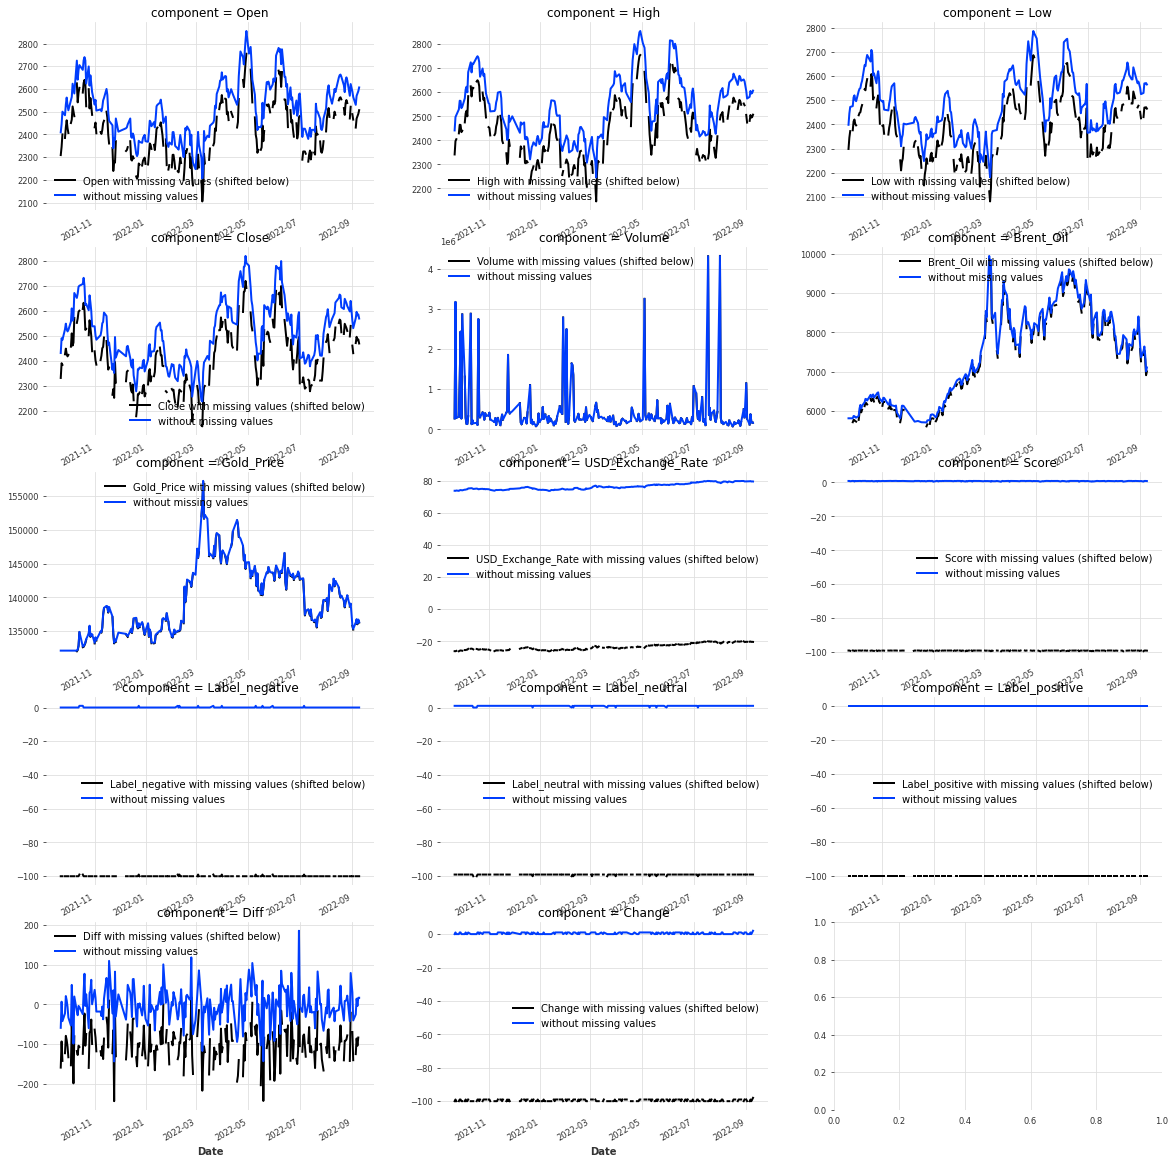

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 10 in this Score.
There is seasonality of order 12 in this Score.
There is seasonality of order 22 in this Score.
There is seasonality of order 12 in this Label_negative.
There is seasonality of order 18 in this Label_negative.
There is seasonality of order 12 in this Label_neutral.
There is seasonality of order 18 in this Label_neutral.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in this Change.
There is seasonality of order 23 in this Change.


2022-09-22 15:18:22 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-22 15:18:22 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-22 15:18:22 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-22 15:18:22 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-22 15:18:46 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


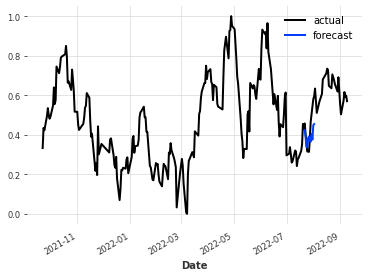

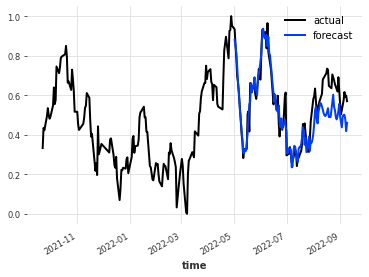

MAPE (using covariates) = 11.65%


In [299]:
Train(merged[2],past_covariates=['Open', 'High', 'Low', 'Volume', 'Brent_Oil',
       'Gold_Price', 'USD_Exchange_Rate','Score',
       'Label_negative', 'Label_neutral', 'Label_positive', 'Change'],target='Close',LTSMtype="LSTM")

In [319]:
merged[0] = merged[0].select_dtypes(include=[np.number,'datetime64[ns]'])
Macro = TimeSeries.from_dataframe(df = merged[0],time_col='Date',fill_missing_dates=True,freq='D')
Macro.pd_dataframe()

component        Open       High        Low      Close     Volume  \
Date                                                                
2021-09-22  2409.0000  2441.2500  2398.1500  2430.6000   272044.0   
2021-09-23  2445.0000  2496.9500  2445.0000  2489.6500  3174137.0   
2021-09-24  2500.0000  2504.7000  2472.0000  2482.9500   288081.0   
2021-09-25        NaN        NaN        NaN        NaN        NaN   
2021-09-26        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...   
2022-09-05  2530.0000  2581.0000  2530.0000  2570.2500   119294.0   
2022-09-06  2569.6001  2605.5000  2569.6001  2595.3999   376714.0   
2022-09-07  2579.7000  2594.5000  2569.0500  2581.1499   191624.0   
2022-09-08  2590.0000  2597.0000  2571.0000  2585.2000   164380.0   
2022-09-09  2606.5500  2606.8501  2565.0000  2568.6001   165838.0   

component     Brent_Oil     Gold_Price  USD_Exchange_Rate  Negative  Positive  \
Date                                                                            
2021-09-22          NaN            NaN          73.875150     0.000     0.174   
2021-09-23          NaN            NaN          73.840250     0.081     0.000   
2021-09-24          NaN            NaN          74.046550     0.056     0.086   
2021-09-25          NaN            NaN                NaN       NaN       NaN   
2021-09-26          NaN            NaN                NaN       NaN       NaN   
...                 ...            ...                ...       ...       ...   
2022-09-05  7526.014178  136238.794690          79.790498     0.153     0.099   
2022-09-06  7639.190340  136777.732200          79.895350     0.103     0.167   
2022-09-07  7416.687107  136109.251835          79.650050     0.191     0.101   
2022-09-08  7009.087122  136718.018850          79.706550     0.051     0.110   
2022-09-09  7105.839143  136364.360969          79.656050     0.114     0.208   

component   Neutral  Max_Sentiment_Negative  Max_Sentiment_Neutral     Diff  \
Date                                                                          
2021-09-22    0.826                     0.0                    1.0 -59.0500   
2021-09-23    0.919                     0.0                    1.0   6.7000   
2021-09-24    0.858                     0.0                    1.0 -42.2500   
2021-09-25      NaN                     NaN                    NaN      NaN   
2021-09-26      NaN                     NaN                    NaN      NaN   
...             ...                     ...                    ...      ...   
2022-09-05    0.748                     0.0                    1.0 -25.1499   
2022-09-06    0.730                     0.0                    1.0  14.2500   
2022-09-07    0.708                     0.0                    1.0  -4.0501   
2022-09-08    0.839                     0.0                    1.0  16.5999   
2022-09-09    0.678                     0.0                    1.0      NaN   

component   Change  
Date                
2021-09-22     0.0  
2021-09-23     1.0  
2021-09-24     0.0  
2021-09-25     NaN  
2021-09-26     NaN  
...            ...  
2022-09-05     0.0  
2022-09-06     1.0  
2022-09-07     0.0  
2022-09-08     1.0  
2022-09-09     2.0  

[353 rows x 15 columns]

2022-09-22 16:28:51 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 16:28:51 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 16:28:51 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 16:28:51 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 16:28:51 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

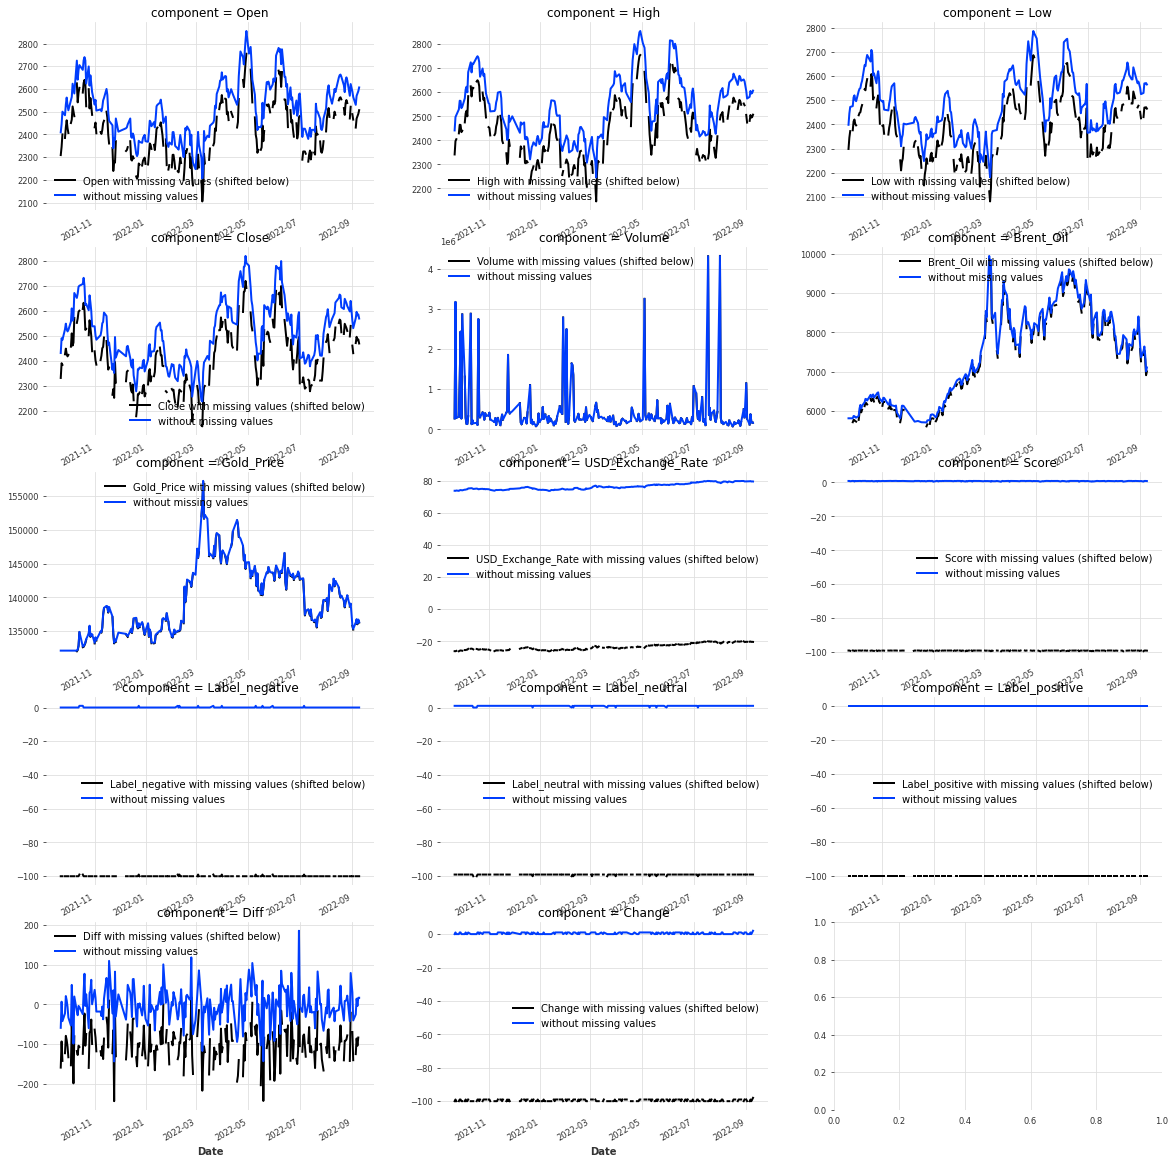

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 10 in this Score.
There is seasonality of order 12 in this Score.
There is seasonality of order 22 in this Score.
There is seasonality of order 12 in this Label_negative.
There is seasonality of order 18 in this Label_negative.
There is seasonality of order 12 in this Label_neutral.
There is seasonality of order 18 in this Label_neutral.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in this Change.
There is seasonality of order 23 in this Change.


2022-09-22 16:28:54 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-22 16:28:54 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-22 16:28:54 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-22 16:28:54 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-22 16:29:24 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


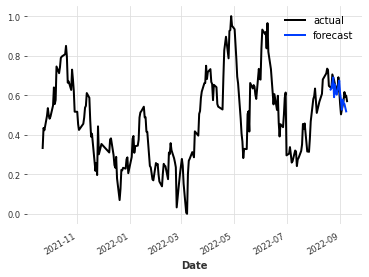

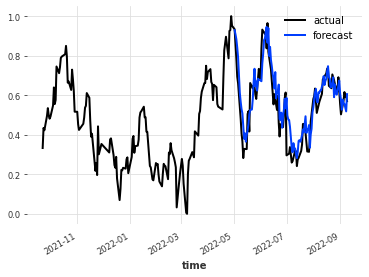

MAPE (using covariates) = 13.80%


In [321]:
pred1,pred2 = Train(merged[2],past_covariates=['Open', 'High', 'Low', 'Volume', 'Brent_Oil',
       'Gold_Price', 'USD_Exchange_Rate','Score',
       'Label_negative', 'Label_neutral', 'Label_positive', 'Change'],target='Close',LTSMtype="LSTM")

2022-09-21 16:48:28 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:48:28 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:48:28 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:48:28 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:48:28 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

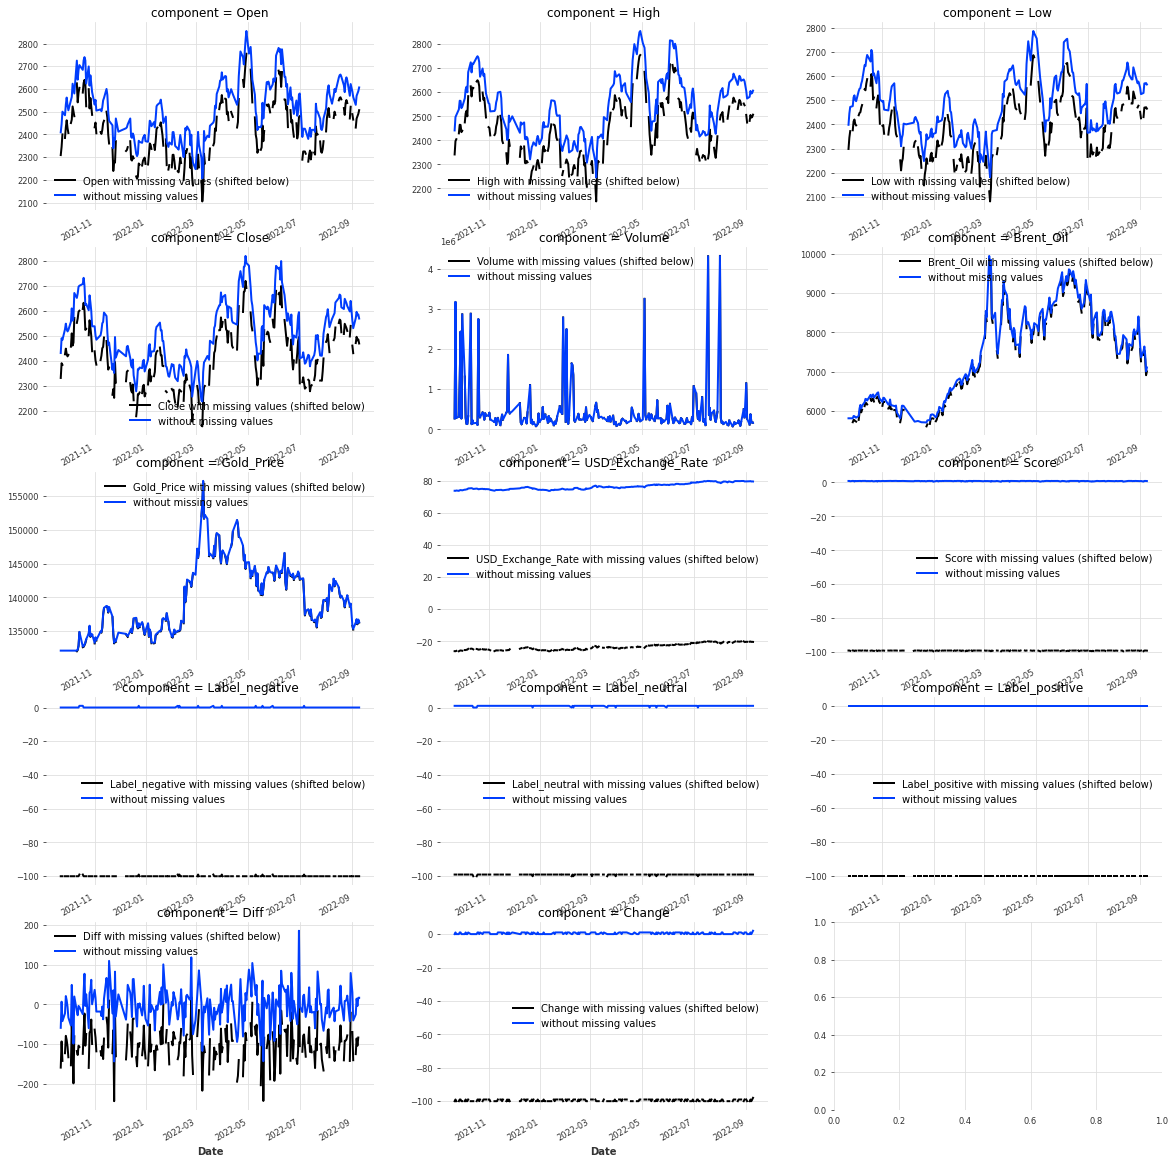

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 10 in this Score.
There is seasonality of order 12 in this Score.
There is seasonality of order 22 in this Score.
There is seasonality of order 12 in this Label_negative.
There is seasonality of order 18 in this Label_negative.
There is seasonality of order 12 in this Label_neutral.
There is seasonality of order 18 in this Label_neutral.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in this Change.
There is seasonality of order 23 in this Change.


2022-09-21 16:48:30 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-21 16:48:30 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-21 16:48:30 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-21 16:48:30 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-21 16:48:45 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


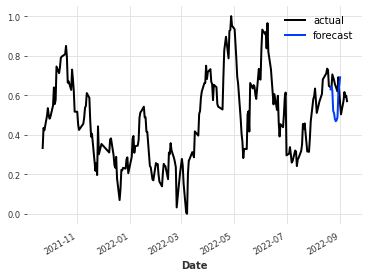

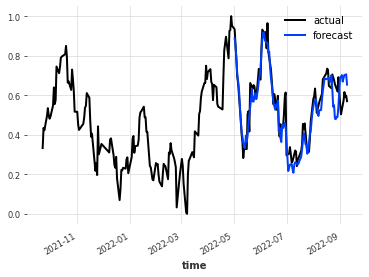

MAPE (using covariates) = 10.14%


In [241]:
Train(merged[2],past_covariates=['Open', 'High', 'Low', 'Volume', 'Brent_Oil',
       'Gold_Price', 'USD_Exchange_Rate','Score',
       'Label_negative', 'Label_neutral', 'Label_positive', 'Change'],target='Close',LTSMtype="LSTM")

2022-09-21 16:51:50 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:51:50 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:51:50 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:51:50 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:51:50 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

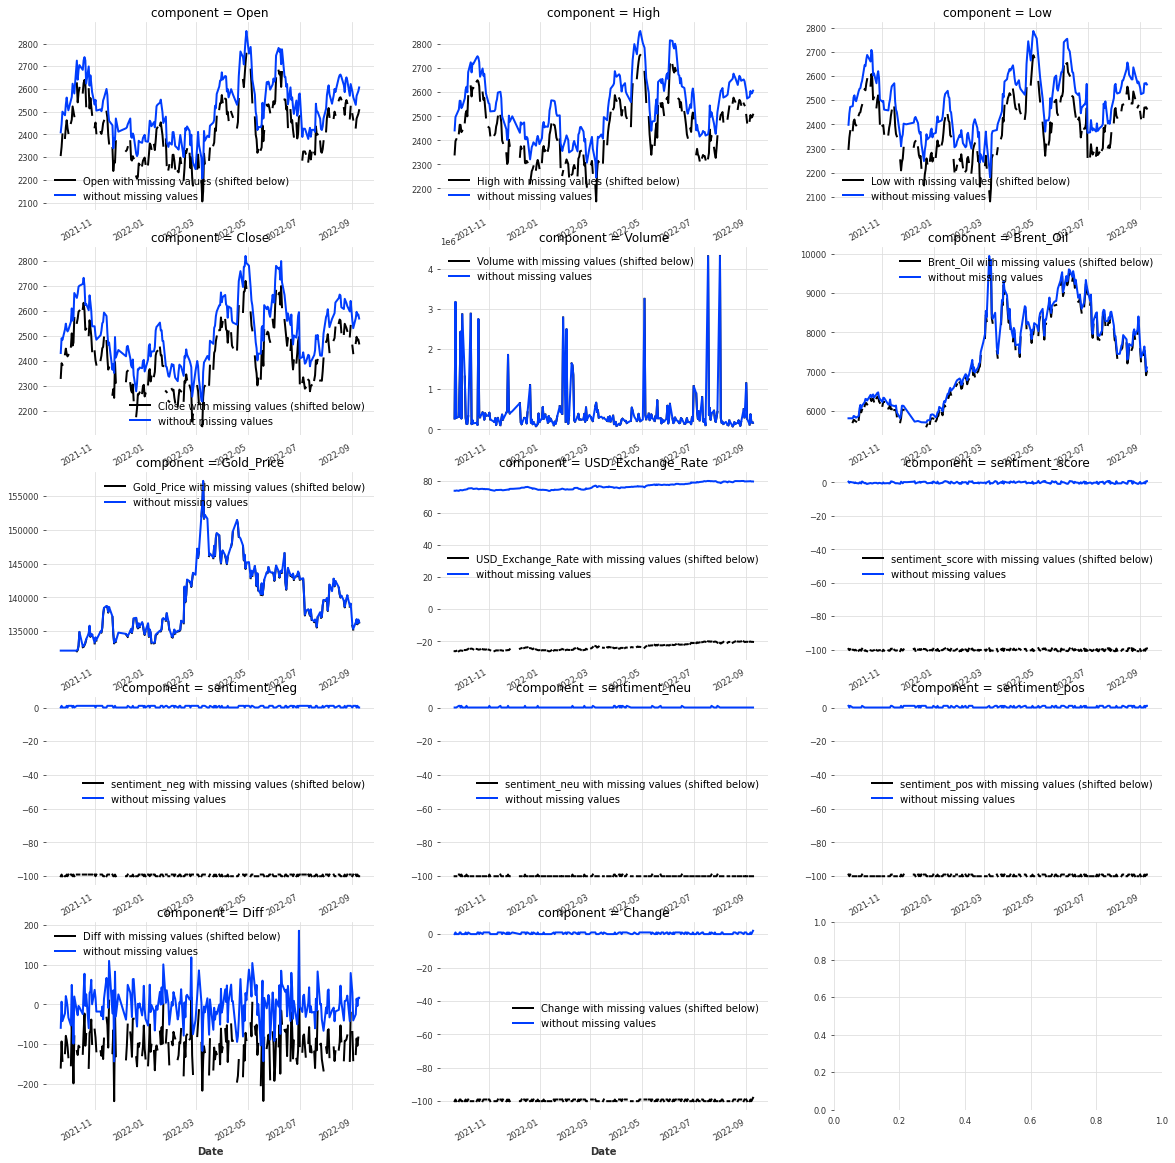

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 7 in this sentiment_score.
There is seasonality of order 13 in this sentiment_score.
There is seasonality of order 16 in this sentiment_score.
There is seasonality of order 21 in this sentiment_score.
There is seasonality of order 7 in this sentiment_neg.
There is seasonality of order 10 in this sentiment_neg.
There is seasonality of order 10 in this sentiment_neu.
There is seasonality of order 7 in this sentiment_pos.
There is seasonality of order 9 in this sentiment_pos.
There is seasonality of order 13 in this sentiment_pos.
There is seasonality of order 16 in this sentiment_pos.
There is seasonality of order 22 in this sentiment_pos.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in 

2022-09-21 16:51:52 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-21 16:51:52 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-21 16:51:52 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-21 16:51:52 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-21 16:52:07 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


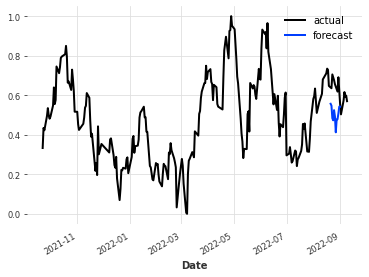

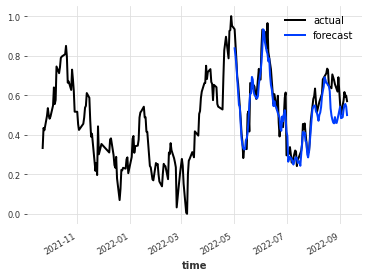

MAPE (using covariates) = 9.66%


In [242]:
Train(merged[1],past_covariates=['Open', 'High', 'Low','Volume', 'Brent_Oil',
       'Gold_Price', 'USD_Exchange_Rate','sentiment_score',
       'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'Change','Diff'],target='Close',LTSMtype="LSTM")

2022-09-21 16:52:08 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:52:08 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:52:08 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:52:08 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 16:52:08 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

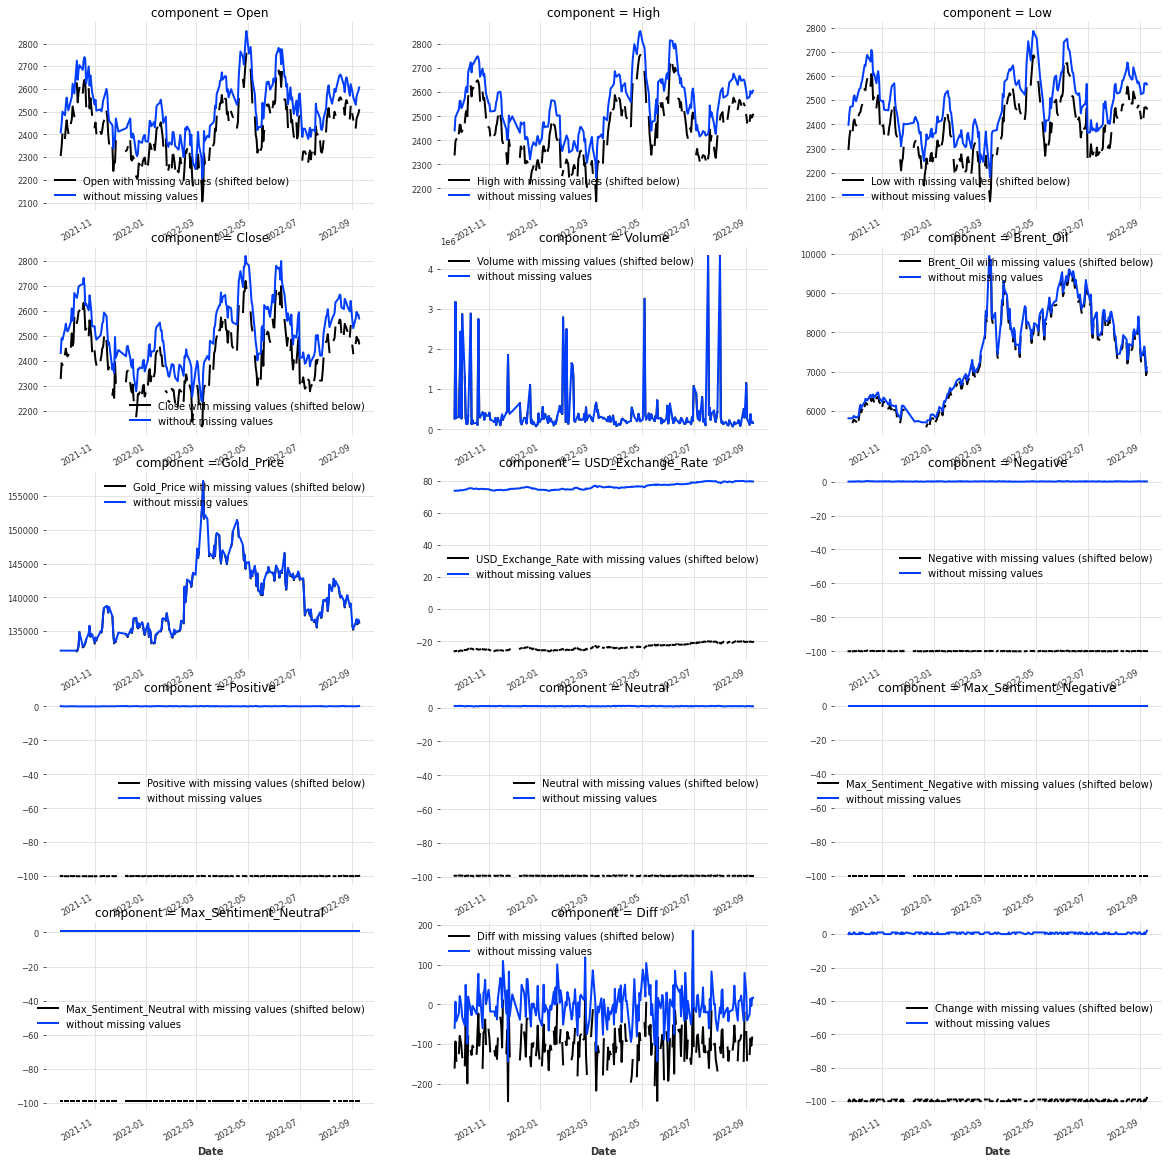

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 8 in this Negative.
There is seasonality of order 10 in this Negative.
There is seasonality of order 21 in this Negative.
There is seasonality of order 8 in this Positive.
There is seasonality of order 16 in this Positive.
There is seasonality of order 23 in this Positive.
There is seasonality of order 6 in this Neutral.
There is seasonality of order 8 in this Neutral.
There is seasonality of order 10 in this Neutral.
There is seasonality of order 12 in this Neutral.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in this Change.
There is seasonality of order 23 in this Change.


2022-09-21 16:52:09 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-21 16:52:09 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-21 16:52:09 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-21 16:52:09 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-21 16:52:24 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


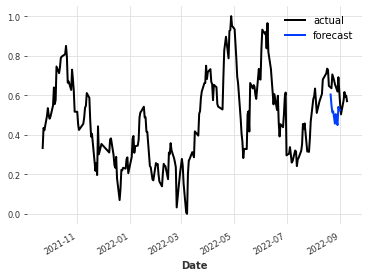

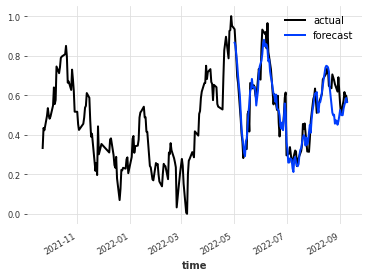

MAPE (using covariates) = 9.20%


In [243]:
Train(merged[0],past_covariates=['Open', 'High', 'Low', 'Volume', 'Brent_Oil',
       'Gold_Price', 'USD_Exchange_Rate', 'Max_Sentiment_Negative',
       'Max_Sentiment_Neutral','Change'],target='Close',LTSMtype="LSTM")

2022-09-22 10:58:53 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 10:58:53 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 10:58:53 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 10:58:53 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 10:58:53 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

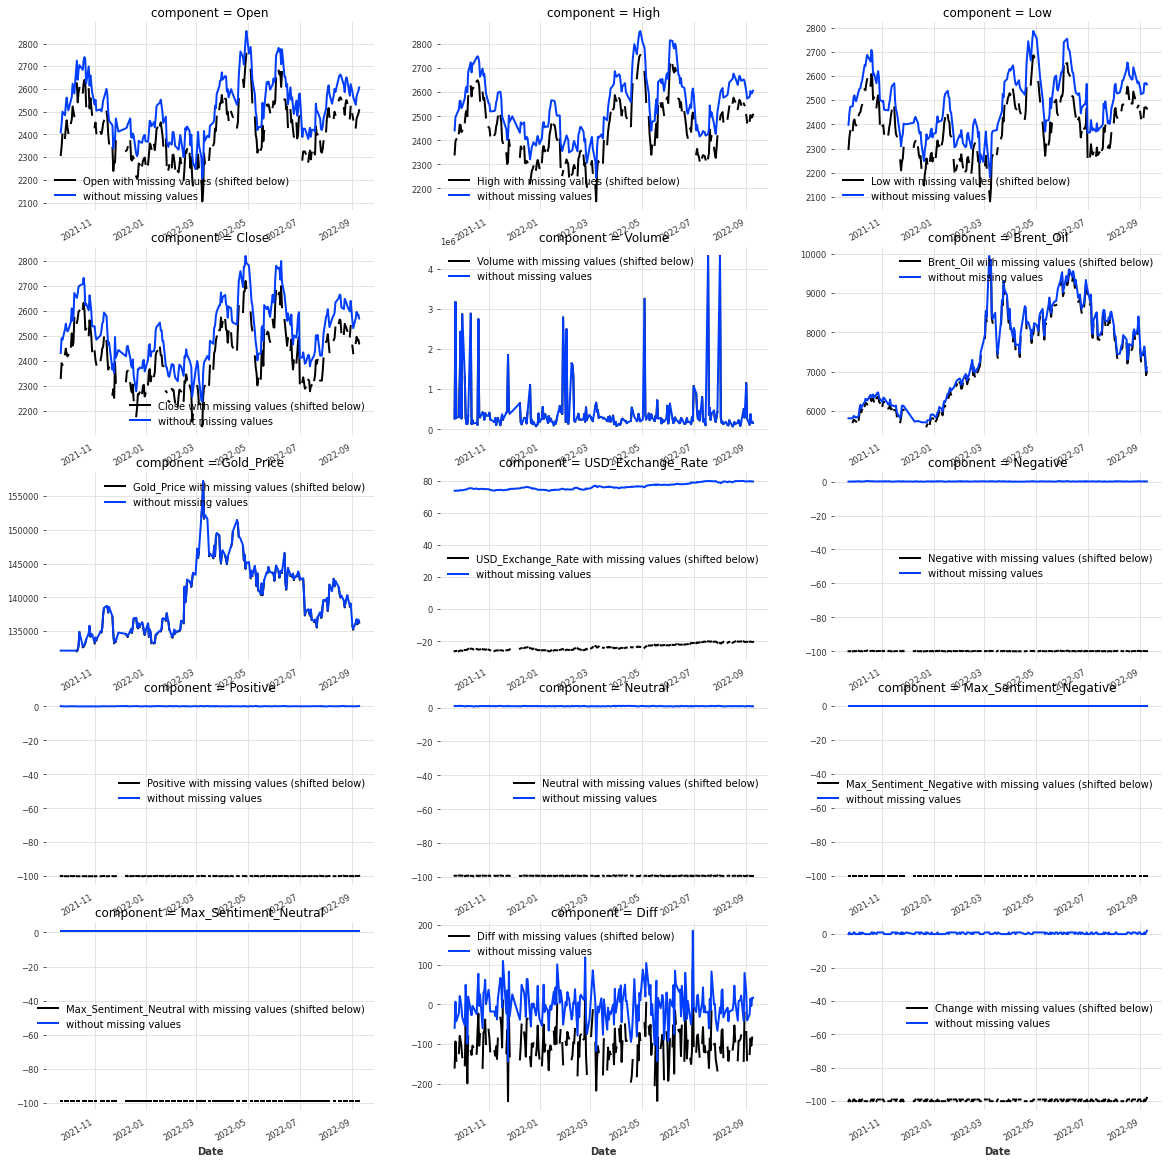

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 8 in this Negative.
There is seasonality of order 10 in this Negative.
There is seasonality of order 21 in this Negative.
There is seasonality of order 8 in this Positive.
There is seasonality of order 16 in this Positive.
There is seasonality of order 23 in this Positive.
There is seasonality of order 6 in this Neutral.
There is seasonality of order 8 in this Neutral.
There is seasonality of order 10 in this Neutral.
There is seasonality of order 12 in this Neutral.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in this Change.
There is seasonality of order 23 in this Change.


2022-09-22 10:58:56 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-22 10:58:56 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-22 10:58:56 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-22 10:58:56 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-22 10:59:11 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


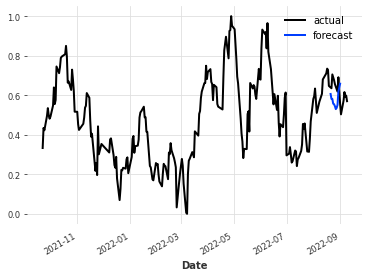

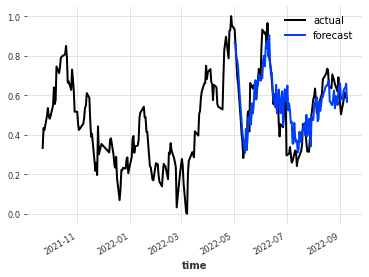

MAPE (using covariates) = 16.91%


In [269]:
Train(merged[0],past_covariates=['Open', 'High', 'Low', 'Volume', 'Brent_Oil',
       'Gold_Price', 'USD_Exchange_Rate', 'Max_Sentiment_Negative',
       'Max_Sentiment_Neutral','Change'],target='Close',LTSMtype="GRU")

2022-09-22 11:00:07 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 11:00:07 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 11:00:07 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 11:00:07 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 11:00:07 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

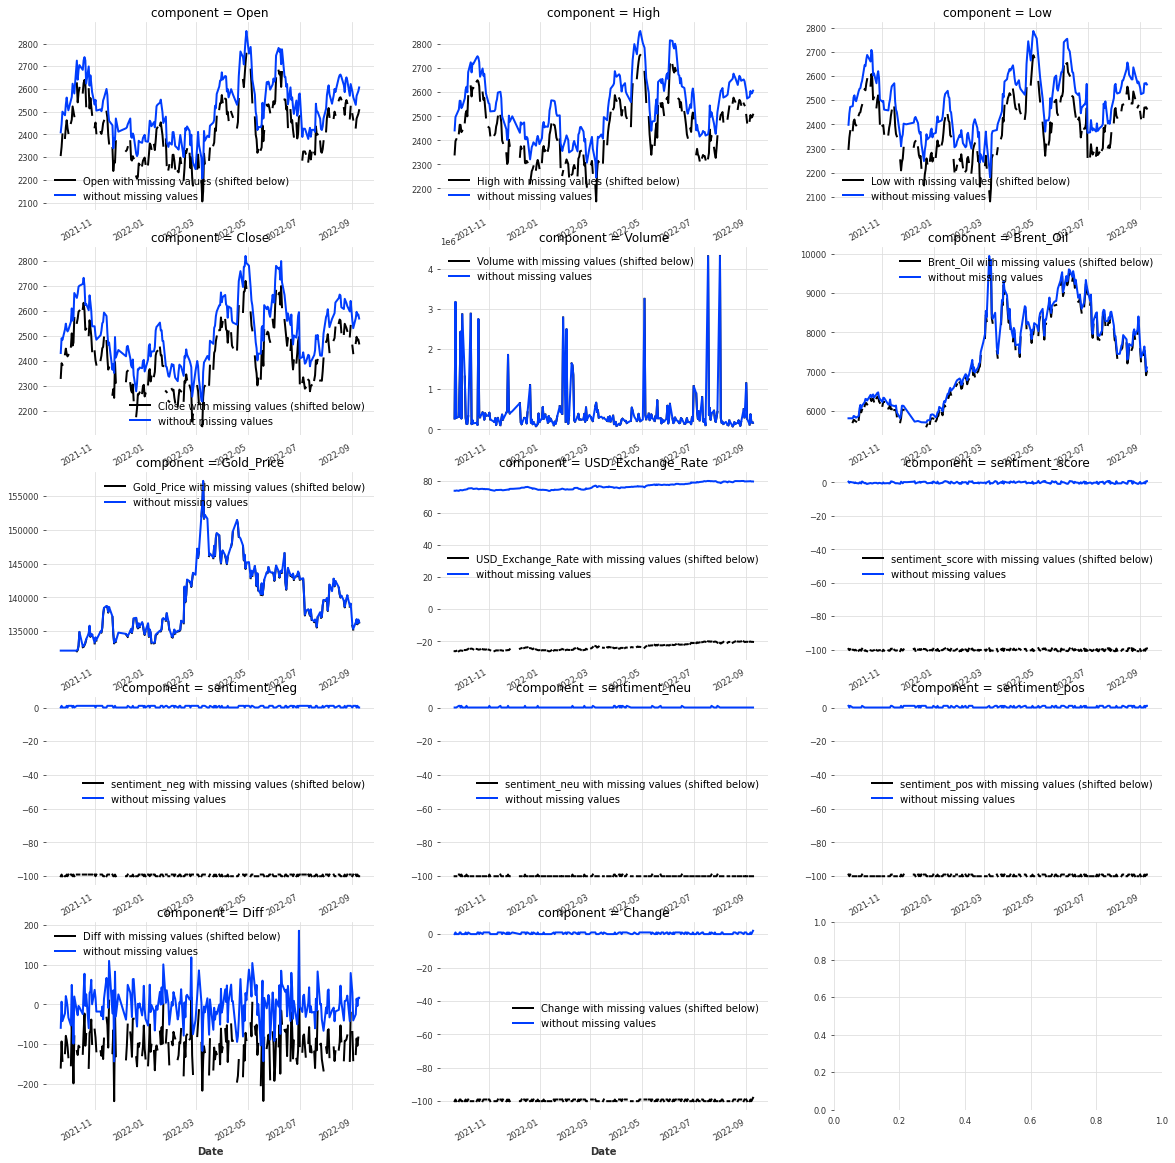

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 7 in this sentiment_score.
There is seasonality of order 13 in this sentiment_score.
There is seasonality of order 16 in this sentiment_score.
There is seasonality of order 21 in this sentiment_score.
There is seasonality of order 7 in this sentiment_neg.
There is seasonality of order 10 in this sentiment_neg.
There is seasonality of order 10 in this sentiment_neu.
There is seasonality of order 7 in this sentiment_pos.
There is seasonality of order 9 in this sentiment_pos.
There is seasonality of order 13 in this sentiment_pos.
There is seasonality of order 16 in this sentiment_pos.
There is seasonality of order 22 in this sentiment_pos.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in 

2022-09-22 11:00:09 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-22 11:00:09 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-22 11:00:09 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-22 11:00:09 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-22 11:00:27 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


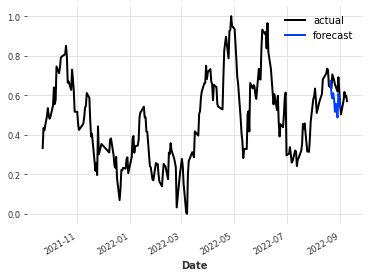

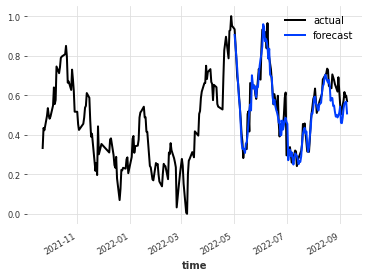

MAPE (using covariates) = 8.60%


In [270]:
Train(merged[1],past_covariates=['Open', 'High', 'Low','Volume', 'Brent_Oil',
       'Gold_Price', 'USD_Exchange_Rate','sentiment_score',
       'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'Change','Diff'],target='Close',LTSMtype="GRU")

2022-09-22 11:00:28 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 11:00:28 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 11:00:28 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 11:00:28 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-22 11:00:28 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

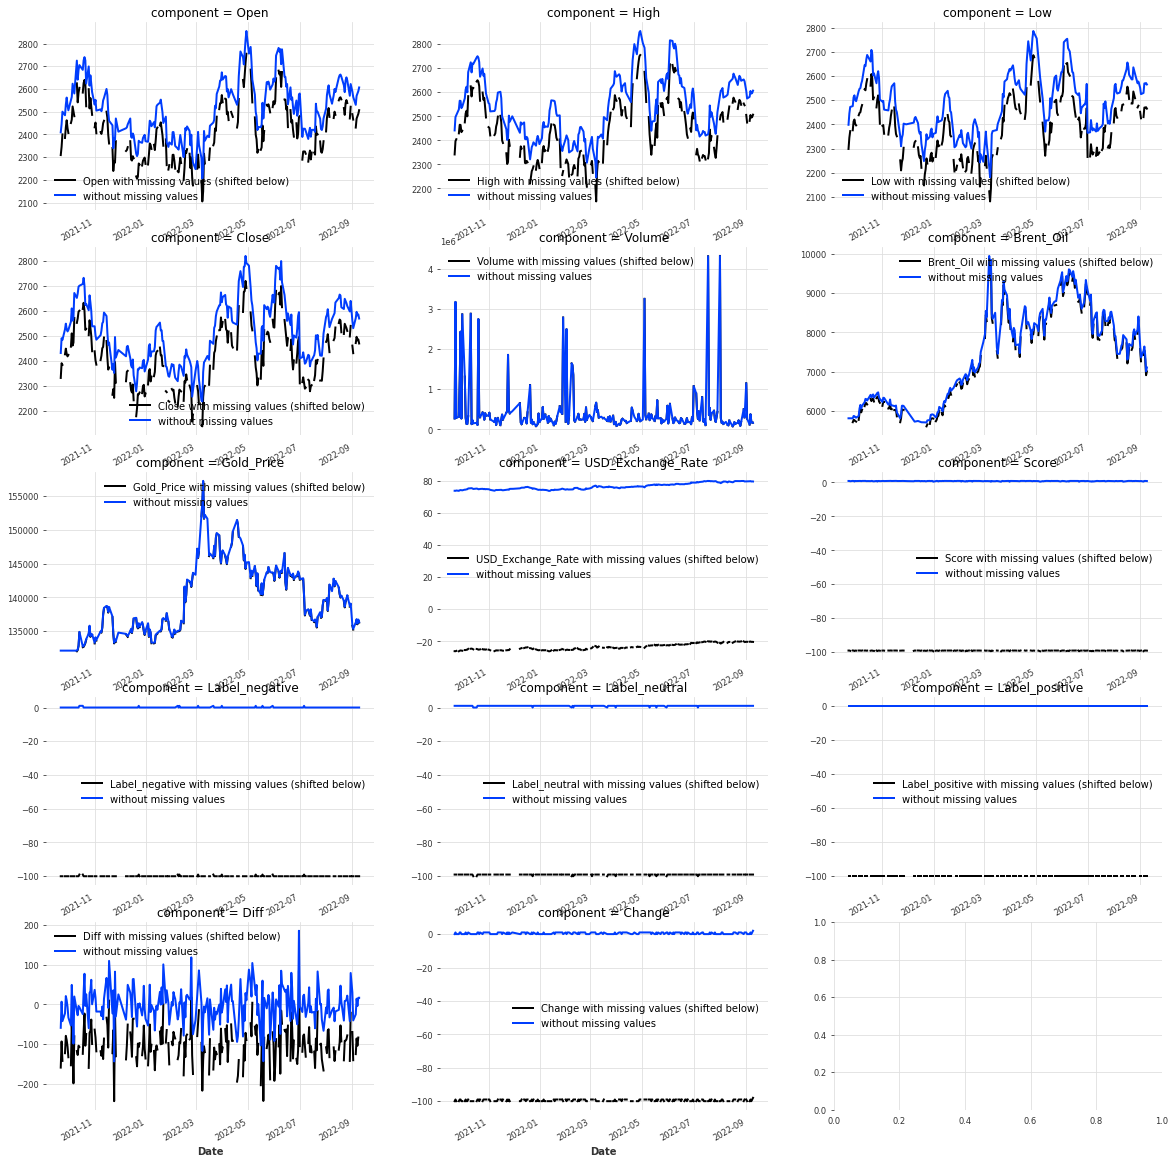

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 10 in this Score.
There is seasonality of order 12 in this Score.
There is seasonality of order 22 in this Score.
There is seasonality of order 12 in this Label_negative.
There is seasonality of order 18 in this Label_negative.
There is seasonality of order 12 in this Label_neutral.
There is seasonality of order 18 in this Label_neutral.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in this Change.
There is seasonality of order 23 in this Change.


2022-09-22 11:00:30 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-22 11:00:30 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-22 11:00:30 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-22 11:00:30 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-22 11:00:45 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


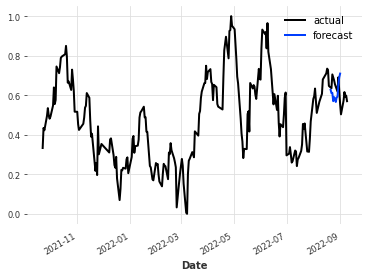

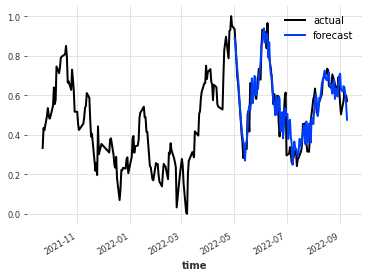

MAPE (using covariates) = 11.63%


In [271]:
Train(merged[2],past_covariates=['Open', 'High', 'Low', 'Volume', 'Brent_Oil',
       'Gold_Price', 'USD_Exchange_Rate','Score',
       'Label_negative', 'Label_neutral', 'Label_positive', 'Change'],target='Close',LTSMtype="GRU")

2022-09-21 14:59:13 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 14:59:13 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 14:59:13 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 14:59:13 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 14:59:13 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

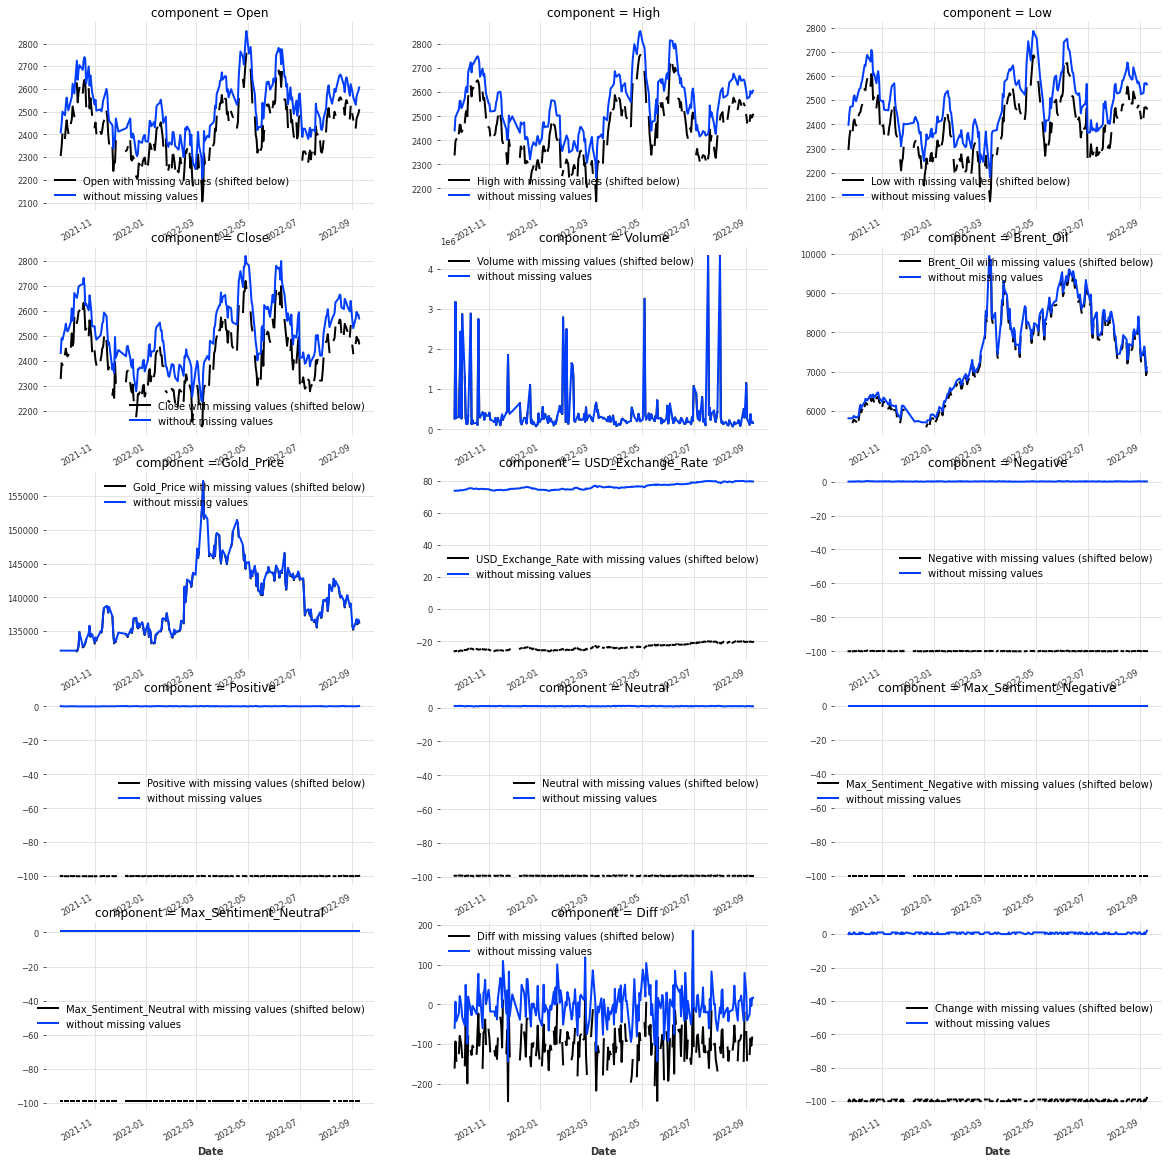

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 8 in this Negative.
There is seasonality of order 10 in this Negative.
There is seasonality of order 21 in this Negative.
There is seasonality of order 8 in this Positive.
There is seasonality of order 16 in this Positive.
There is seasonality of order 23 in this Positive.
There is seasonality of order 6 in this Neutral.
There is seasonality of order 8 in this Neutral.
There is seasonality of order 10 in this Neutral.
There is seasonality of order 12 in this Neutral.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in this Change.
There is seasonality of order 23 in this Change.


2022-09-21 14:59:16 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-21 14:59:16 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-21 14:59:16 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-21 14:59:16 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-21 14:59:16 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 4.3 K 
4 | fc            | Sequential       | 624   
---------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.039     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

2022-09-21 14:59:41 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


Predicting: 8it [00:00, ?it/s]

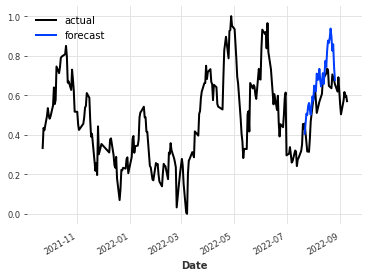

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

Predicting: 8it [00:00, ?it/s]

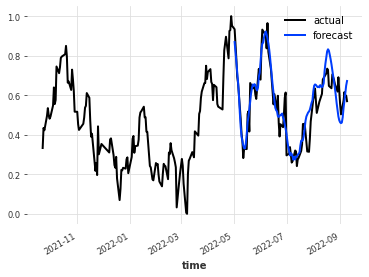

MAPE (using covariates) = 11.41%


In [206]:
Train(merged[0])

2022-09-21 15:10:18 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 15:10:18 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 15:10:18 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 15:10:18 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 15:10:18 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

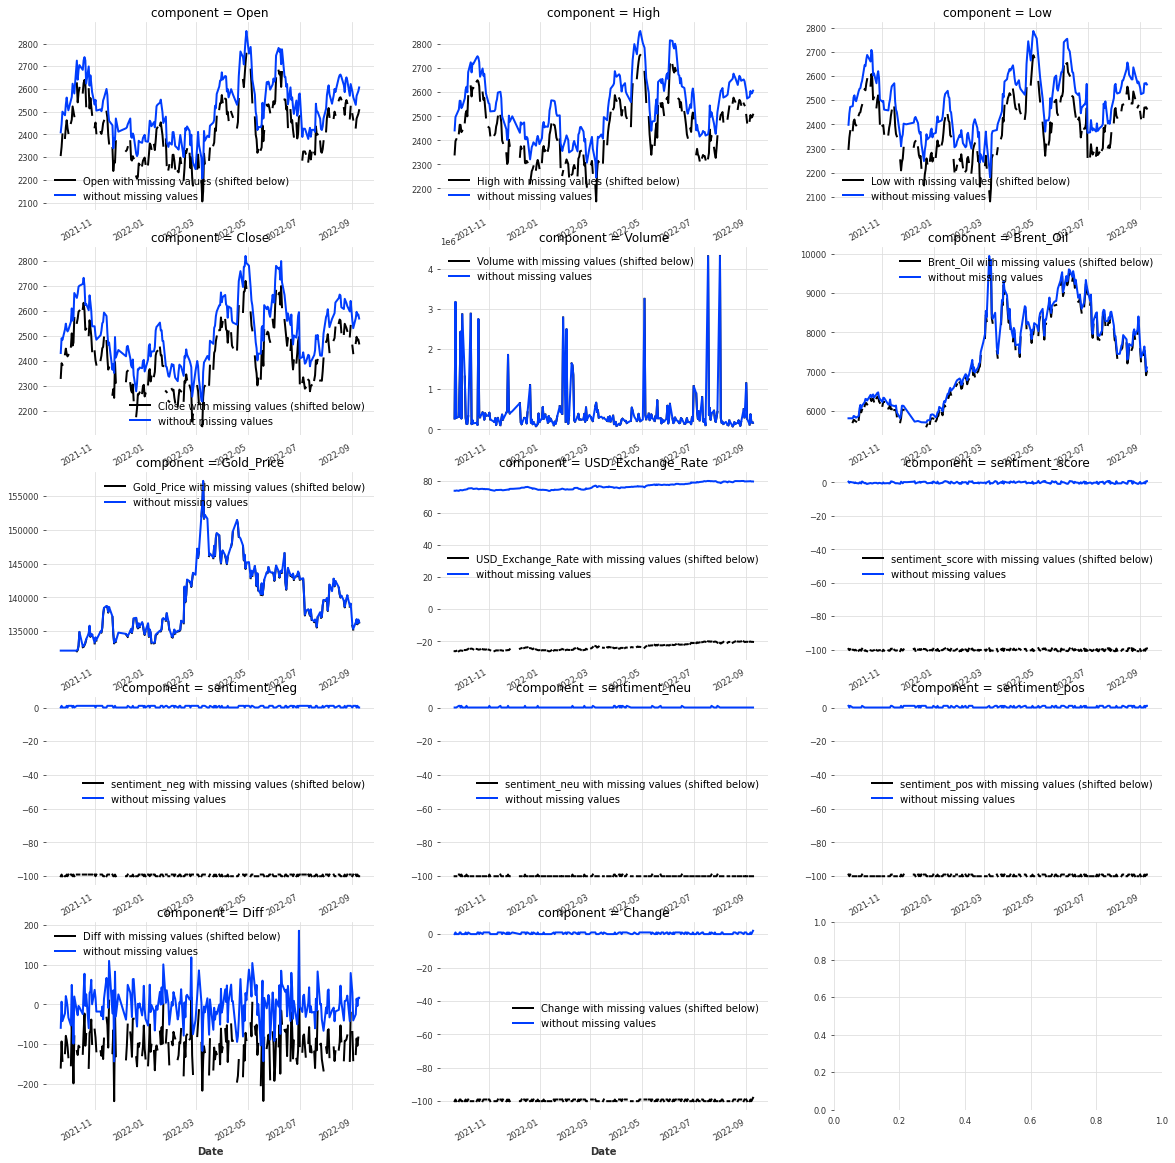

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 7 in this sentiment_score.
There is seasonality of order 13 in this sentiment_score.
There is seasonality of order 16 in this sentiment_score.
There is seasonality of order 21 in this sentiment_score.
There is seasonality of order 7 in this sentiment_neg.
There is seasonality of order 10 in this sentiment_neg.
There is seasonality of order 10 in this sentiment_neu.
There is seasonality of order 7 in this sentiment_pos.
There is seasonality of order 9 in this sentiment_pos.
There is seasonality of order 13 in this sentiment_pos.
There is seasonality of order 16 in this sentiment_pos.
There is seasonality of order 22 in this sentiment_pos.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in 

2022-09-21 15:10:20 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-21 15:10:20 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-21 15:10:20 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-21 15:10:20 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-21 15:10:44 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


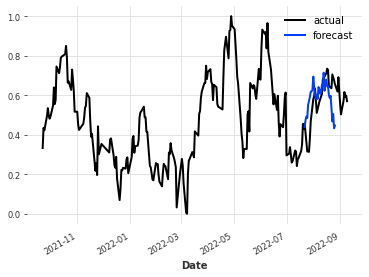

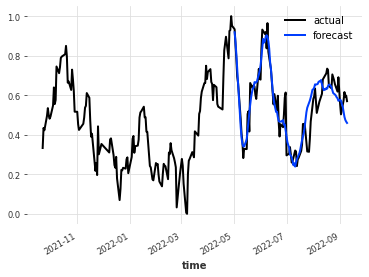

MAPE (using covariates) = 11.70%


In [213]:
Train(merged[1])

2022-09-21 15:10:45 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 15:10:45 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 15:10:45 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 15:10:45 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-21 15:10:45 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

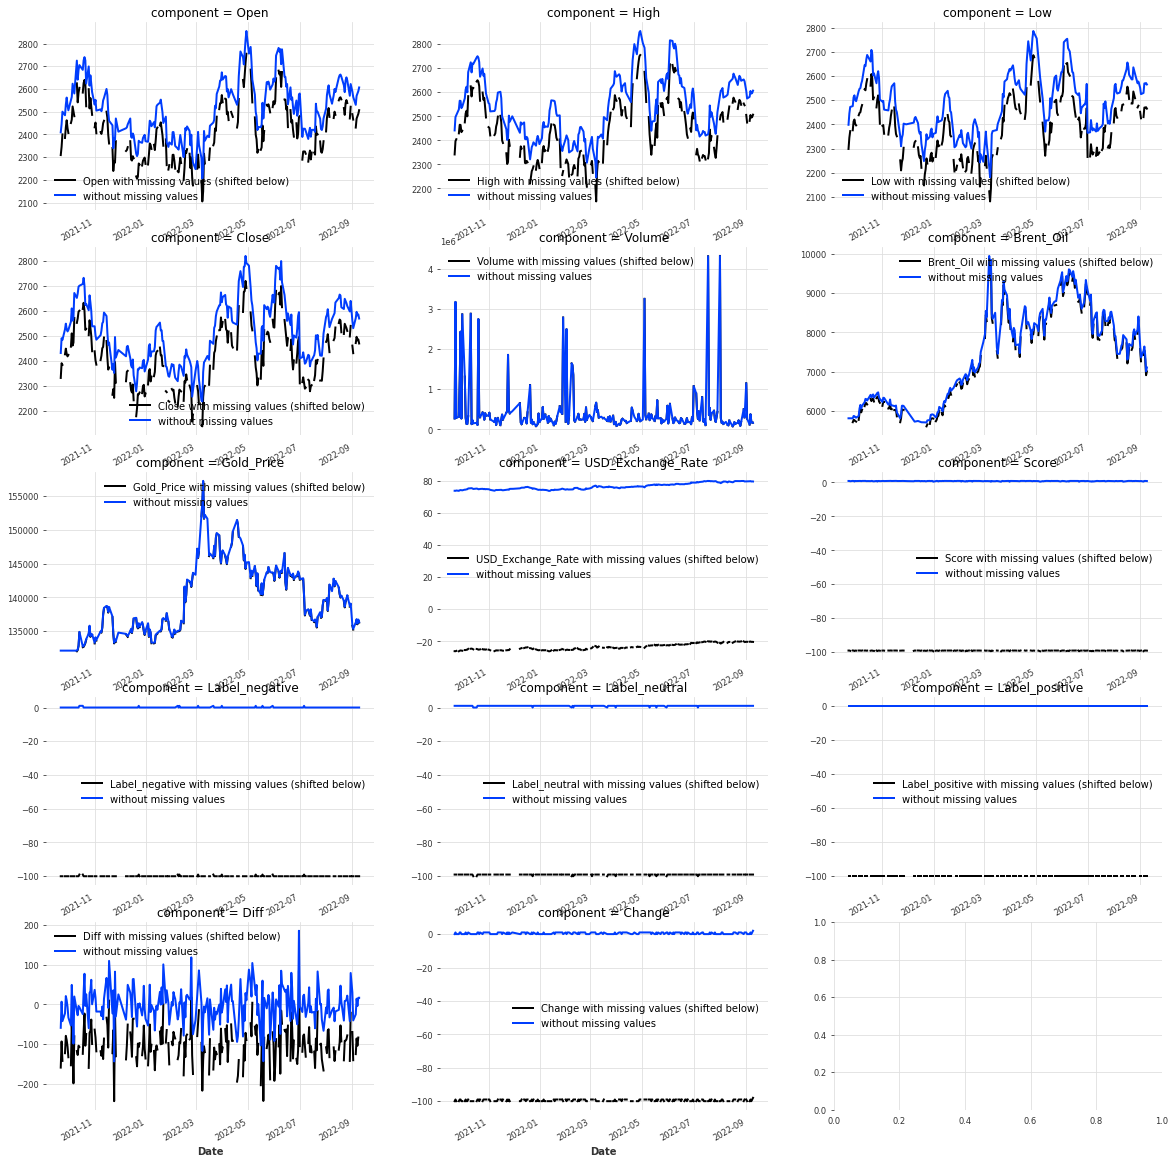

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 10 in this Score.
There is seasonality of order 12 in this Score.
There is seasonality of order 22 in this Score.
There is seasonality of order 12 in this Label_negative.
There is seasonality of order 18 in this Label_negative.
There is seasonality of order 12 in this Label_neutral.
There is seasonality of order 18 in this Label_neutral.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 6 in this Change.
There is seasonality of order 11 in this Change.
There is seasonality of order 14 in this Change.
There is seasonality of order 23 in this Change.
['Diff', 'Close', 'Label_neutral', 'High', 'Low', 'Brent_Oil', 'Label_negative', 'Volume', 'Gold_Price', 'USD_Exchange_Rate', 'Score', 'Label_positive', 'Open', 'Change']


2022-09-21 15:10:47 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-21 15:10:47 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-21 15:10:47 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-21 15:10:47 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-21 15:11:07 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


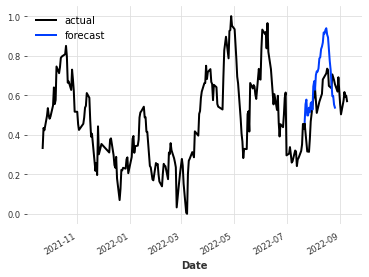

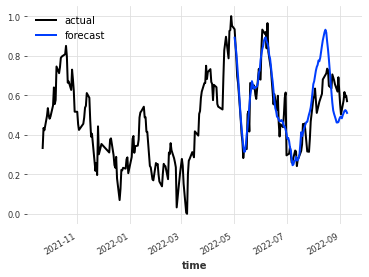

MAPE (using covariates) = 14.48%


In [214]:
Train(merged[2])

In [50]:
df1 = pd.read_excel('./Stock-data-weekly1.xlsx')
# Removing the first unamed column 
df1 = df1.drop(columns=['Unnamed: 0'])

# Sentiment Data 
df2 = pd.read_excel('./daily-articles1.xlsx')
df2 = df2.drop(columns='Unnamed: 0')

#Changing the dtype of the date column to get into correct date-time format
df1.Date = pd.to_datetime(df1.Date)

# Renaming the last two columns to the right name 
#! Put this in the data collection code
renamingcols = {'INR_x':'Gold_Price','INR_y':'USD_Exchange_Rate','INR':'Brent_Oil'}
df1 = df1.rename(columns=renamingcols)

2022-09-26 12:48:35 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-26 12:48:35 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-26 12:48:35 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-26 12:48:35 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022-09-26 12:48:35 matplotlib.legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is calle

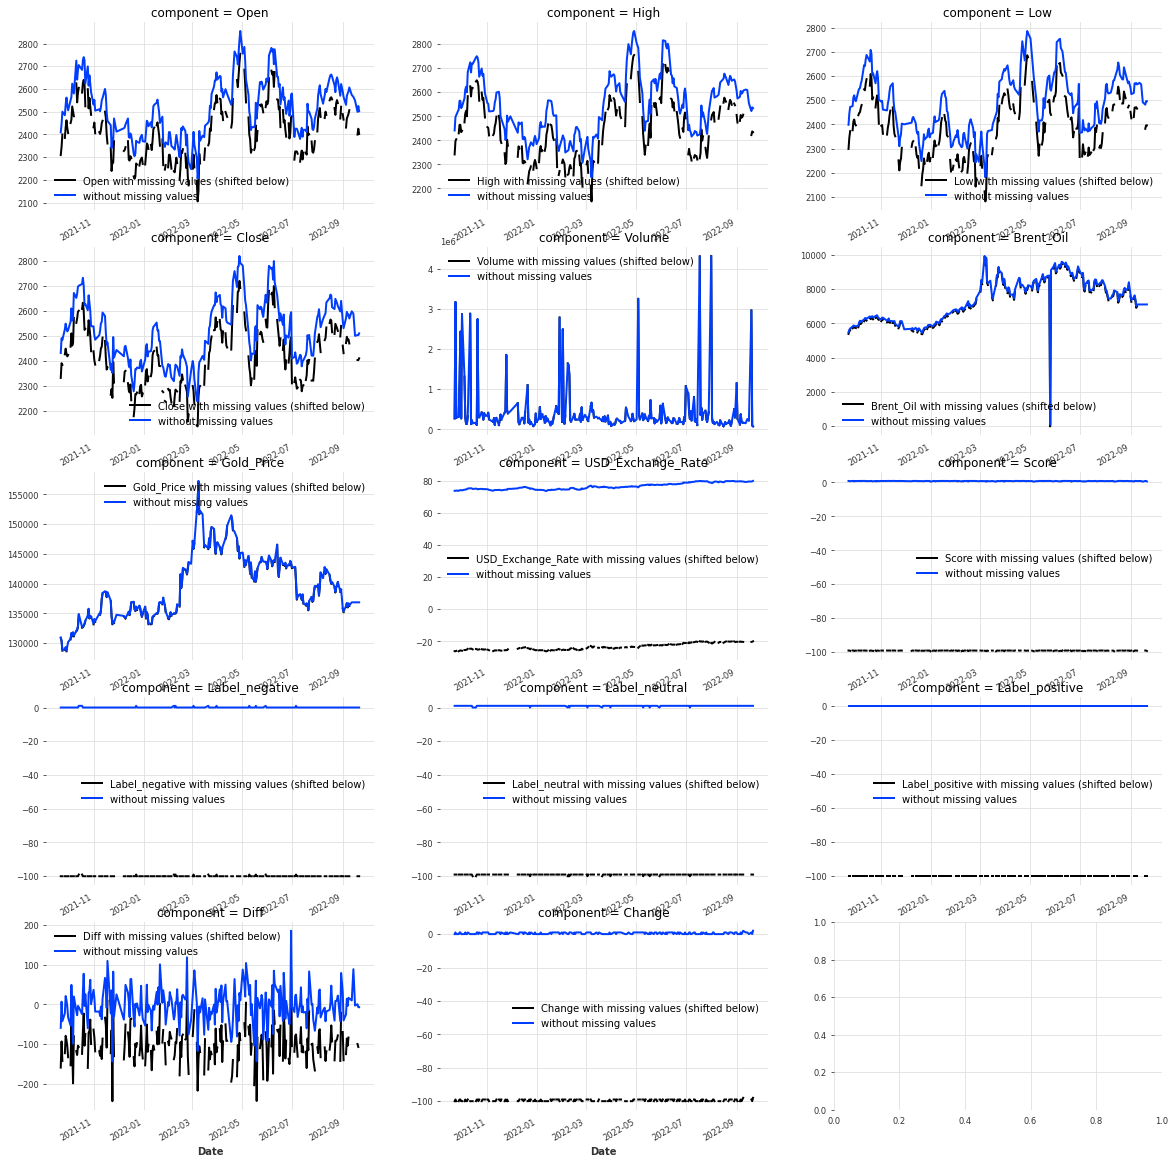

There is seasonality of order 9 in this Volume.
There is seasonality of order 14 in this Volume.
There is seasonality of order 18 in this Volume.
There is seasonality of order 15 in this Brent_Oil.
There is seasonality of order 12 in this Score.
There is seasonality of order 22 in this Score.
There is seasonality of order 8 in this Label_negative.
There is seasonality of order 12 in this Label_negative.
There is seasonality of order 18 in this Label_negative.
There is seasonality of order 8 in this Label_neutral.
There is seasonality of order 12 in this Label_neutral.
There is seasonality of order 18 in this Label_neutral.
There is seasonality of order 12 in this Diff.
There is seasonality of order 23 in this Diff.
There is seasonality of order 11 in this Change.
There is seasonality of order 15 in this Change.
There is seasonality of order 23 in this Change.


2022-09-26 12:48:38 pytorch_lightning.utilities.rank_zero INFO: GPU available: True (mps), used: False
2022-09-26 12:48:38 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-26 12:48:38 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-26 12:48:38 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-26 12:49:11 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


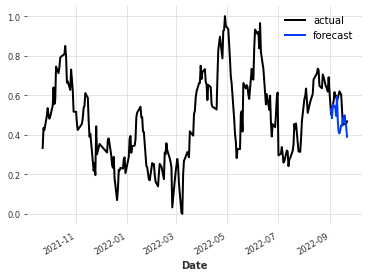

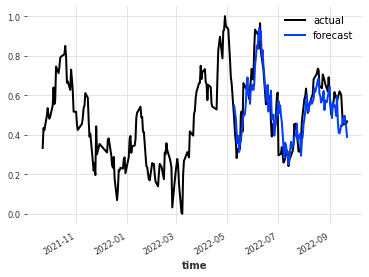

MAPE (using covariates) = 14.23%


In [146]:
merged1,listdfs1 =  all(df1,df2)
mergedLatest = mergingData(merged,merged1)
PredActual = TrainCnn(mergedLatest[2],past_covariates=['Open', 'High', 'Low', 'Volume', 'Brent_Oil',
       'Gold_Price', 'USD_Exchange_Rate','Score',
       'Label_negative', 'Label_neutral', 'Label_positive', 'Change'],target='Close',LTSMtype="LSTM")
g = extractPred(PredActual[0],PredActual[1])
g['Diff'] = g.Actual - g.Prediction
g['Dff1'] = np.sign(g.Actual.diff())
g['Dff2'] = np.sign(g.Prediction.diff())
g['Right'] = g.apply(lambda x: 1 if(x.Dff1 == x.Dff2) else 0 ,axis=1)# right = []
# lambda k,v: k:v for k,v in np.sign(g.Actual.diff()), np.sign(g.Prediction.diff())


In [147]:
g['Right'].value_counts(normalize=True)

0    0.75
1    0.25
Name: Right, dtype: float64

In [ ]:
import torch.nn as nn 
from torch import nn, Tensor
import positional_encoder as pe
import torch.nn.functional as F

class TimeSeriesTransformer(nn.Module):

    """
    This class implements a transformer model that can be used for times series
    forecasting. This time series transformer model is based on the paper by
    Wu et al (2020) [1]. The paper will be referred to as "the paper".
    A detailed description of the code can be found in my article here:
    https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e
    In cases where the paper does not specify what value was used for a specific
    configuration/hyperparameter, this class uses the values from Vaswani et al
    (2017) [2] or from PyTorch source code.
    Unlike the paper, this class assumes that input layers, positional encoding 
    layers and linear mapping layers are separate from the encoder and decoder, 
    i.e. the encoder and decoder only do what is depicted as their sub-layers 
    in the paper. For practical purposes, this assumption does not make a 
    difference - it merely means that the linear and positional encoding layers
    are implemented inside the present class and not inside the 
    Encoder() and Decoder() classes.
    [1] Wu, N., Green, B., Ben, X., O'banion, S. (2020). 
    'Deep Transformer Models for Time Series Forecasting: 
    The Influenza Prevalence Case'. 
    arXiv:2001.08317 [cs, stat] [Preprint]. 
    Available at: http://arxiv.org/abs/2001.08317 (Accessed: 9 March 2022).
    [2] Vaswani, A. et al. (2017) 
    'Attention Is All You Need'.
    arXiv:1706.03762 [cs] [Preprint]. 
    Available at: http://arxiv.org/abs/1706.03762 (Accessed: 9 March 2022).
    """

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        out_seq_len: int=58,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=1
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer 
                                     of the decoder
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 because we're
                                    only forecasting FCR-N prices in DK2, but in
                                    we wanted to also predict FCR-D with the same
                                    model, num_predicted_features should be 2.
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len

        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )

        # Create positional encoder
        self.positional_encoding_layer = pe.PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length. 
        # (https://github.com/huggingface/transformers/issues/4083)
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        #print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        #if src_mask is not None:
            #print("From model.forward(): Size of src_mask: {}".format(src_mask.size()))
        #if tgt_mask is not None:
            #print("From model.forward(): Size of tgt_mask: {}".format(tgt_mask.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        #print("From model.forward(): decoder_output shape after decoder: {}".format(decoder_output.shape))

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        #print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output